## Подготовка данных

In [1]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from catboost import CatBoostRegressor

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> Спасибо!
</div>

In [3]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    from google.colab import drive
    drive.mount('/content/drive')
    data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/14/taxi.csv', index_col=[0], parse_dates=[0])


In [4]:
RANDOM_STATE = 12345

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

## Анализ данных

Скользящее среднее и стандартное отклонение.

Text(0.5, 1.0, 'std')

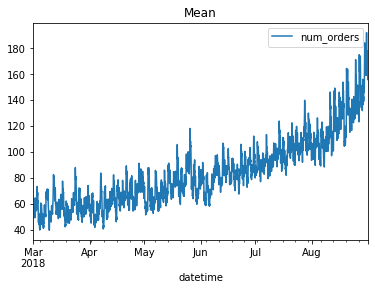

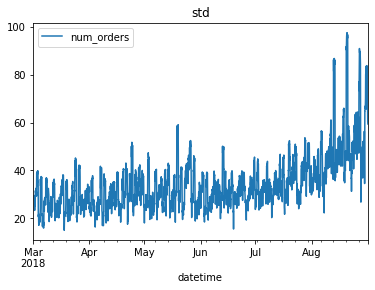

In [7]:
data.rolling(20).mean().plot()
plt.title('Mean')

data.rolling(20).std().plot()
plt.title('std')

Построю график тренда для предсказываемого ряда

In [8]:
decomposed = seasonal_decompose(data)

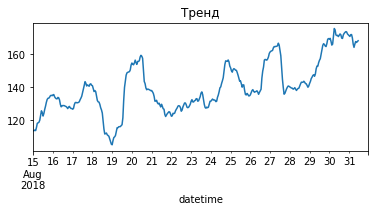

In [9]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend['2018-08-15':'2018-08-31'].plot(ax=plt.gca())
plt.title('Тренд');

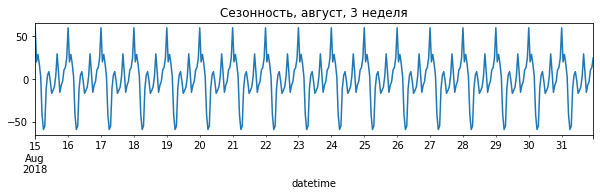

In [10]:
plt.figure(figsize=(10, 7))
plt.subplot(311)
decomposed.seasonal['2018-08-15':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность, август, 3 неделя');

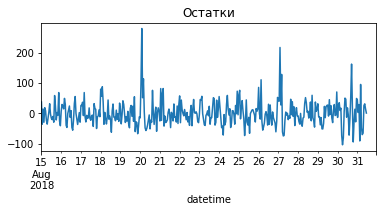

In [11]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.resid['2018-08-15':'2018-08-31'].plot(ax=plt.gca())
plt.title('Остатки');

Промежуточные выводы:
1. Загружены и проанализированны данные.
2. Опрделено среднее и стандарное отклонение. Данные представляют собой нестационарный времянной ряд.
3. Проанализорован тренд - восходящий.
4. Проанализирована сезонность. 
    4.1. Весной и летом графики сезонности схожи.
    4.2. В течении недели наблюдается рост заказов в пятницу и понедельник. Спад в среду и воскресенье.

## Обучение моделей

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['year'] = data.index.year
    data_new['month'] = data.index.month
    data_new['day'] = data.index.day
    data_new['hour'] = data.index.hour
    data_new['dayofweek'] = data.index.dayofweek

    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_new



In [13]:
data_new = make_features(data, 2, 3)

data_new = data_new.dropna()

features = data_new.drop('num_orders', axis =1)
target = data_new['num_orders']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, shuffle = False)



In [14]:
model = LinearRegression()
model.fit(features_train, target_train)
predicts = model.predict(features_test)

In [15]:
rmse = mean_squared_error(target_test, predicts)

In [16]:
print('rmse linear regression', rmse)

rmse linear regression 2749.050504033906


Дерево решений

In [17]:
model = DecisionTreeRegressor(random_state=RANDOM_STATE)

In [18]:
model.fit(features_train, target_train)
predicts = model.predict(features_test)
rmse = mean_squared_error(target_test, predicts)
print('rmse Tree', rmse)

rmse Tree 2887.925339366516


Случайный лес

In [19]:
TSCV = TimeSeriesSplit(n_splits=3)

In [20]:
model = RandomForestRegressor()
params = {
    'max_depth': [1, 3, 5, 10],
    'n_estimators': [5, 10, 15, 20]}

grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv = TSCV)

In [21]:
grid.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 3, 5, 10],
                         'n_estimators': [5, 10, 15, 20]},
             scoring='neg_mean_squared_error')

In [22]:
model = RandomForestRegressor(max_depth=grid.best_params_['max_depth'], n_estimators = grid.best_params_['n_estimators'], random_state=RANDOM_STATE)
model.fit(features_train, target_train)

RandomForestRegressor(max_depth=10, n_estimators=20, random_state=12345)

In [23]:
predicts_rand_for = model.predict(features_test)

In [24]:
RMSE_rand_for = mean_squared_error(target_test, predicts_rand_for, squared=False)
print('rmse forest', RMSE_rand_for)

rmse forest 48.91801623299428


CatBoost

In [25]:
model = CatBoostRegressor(silent = True)
params = {'depth': [6,8,10],
          'learning_rate': [0.01, 0.03, 0.05],
          'iterations': [30, 60, 90, 120, 150]}

grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv = TSCV)

In [26]:
grid.fit(features_train, target_train)
model = CatBoostRegressor(depth = grid.best_params_['depth'], learning_rate = grid.best_params_['learning_rate'],
                          iterations = grid.best_params_['iterations'], silent = True)
model.fit(features_train, target_train)

In [27]:
predicts_CB = model.predict(features_test)
RMSE_CB = mean_squared_error(target_test, predicts_CB, squared=False)
print('rmse CatBoost', RMSE_CB)

rmse CatBoost 47.77433116700838


In [28]:
t_p = pd.DataFrame(target_test)

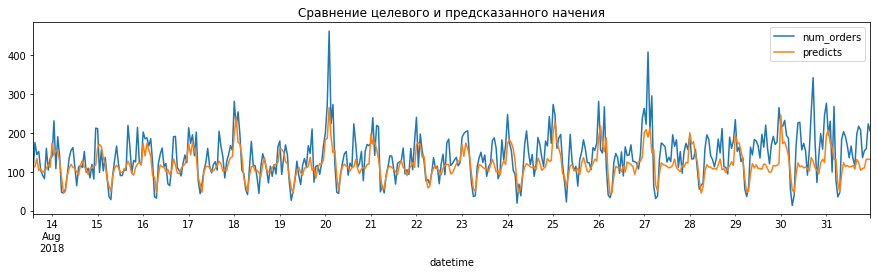

In [30]:
t_p['predicts'] = predicts_CB
plt.figure(figsize=(15, 12))
plt.subplot(311)
t_p.plot(ax=plt.gca())
plt.title('Сравнение целевого и предсказанного начения');

Поомежуточные выводы:
1. Созданы признаки для обучния моделей.
2. Данные разбиты на обучающую и тестовые выборки.
3. Обучны модели линейной регресии, решающего дерева, случайного леса и CatBoost.
4. лучший результат по метрике RMSE - Catboost.

## Выводы


1. Загружены и проанализированы данные.
2. Времянной ряд - нестационарный.
3. Наблюдается стабильный восходящий тренд количесвта заказаов.
4. Созданы признаки для обучения моделей.
5. Обучены модели и определена лучшая модель.

Лучшая модель по метрике RMSE - Catboost. RMSE = 47.7